In [2]:
%load_ext autoreload
%autoreload 2
import numpy
from matplotlib import pyplot
import sys
#sys.path.append('../../timeseries/')
sys.path.append('../../')
from jax import numpy as jnp
from src_jax import factors
from timeseries_jax import observation_models, state_models
from timeseries_jax.ssm_em import StateSpaceEM

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Generate some data 

Here we generate some simple data, with some sines and additive Gaussian noise.

In [3]:
T = 1000
trange = numpy.arange(T)
Dx = 3
Dz = 3
X = numpy.empty((T,Dx))
X[:,0] = numpy.sin(trange / 20)
X[:,1] = numpy.sin(trange / 10)
X[:,2] = numpy.sin(trange / 5)
noise_x = .2
noise_z = .1
X += noise_x * numpy.random.randn(*X.shape)

# Linear state space model 

We fit a state space model with linear state and observation model to the data.

First we instantiate the state and observation model.

In [10]:
sm = state_models.LinearStateModel(Dz)
om = observation_models.LinearObservationModel(Dx, Dz)
#om.pca_init(X)

In [12]:
ssm_em_lin = StateSpaceEM(jnp.array(X), observation_model=om, state_model=sm)
ssm_em_lin.vars().keys()

dict_keys(['(StateSpaceEM).om(LinearObservationModel).C', '(StateSpaceEM).om(LinearObservationModel).d', '(StateSpaceEM).om(LinearObservationModel).Qx', '(StateSpaceEM).sm(LinearStateModel).Qz', '(StateSpaceEM).sm(LinearStateModel).A', '(StateSpaceEM).sm(LinearStateModel).b'])

Then we give it to the EM object with the data and fit it.

Iteration 10 - llk=-385.3
Iteration 20 - llk=-368.6
EM did converge.


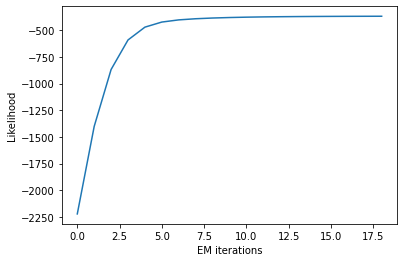

In [6]:
ssm_em_lin = StateSpaceEM(jnp.array(X), observation_model=om, state_model=sm)
ssm_em_lin.run()
pyplot.plot(ssm_em_lin.llk_list[1:])
pyplot.xlabel('EM iterations')
pyplot.ylabel('Likelihood')
pyplot.show()

{}

We show the data density for the training data.

In [ ]:
p_x = ssm_em_lin.compute_data_density()
pyplot.figure(figsize=(10,5))
for ix in range(Dx):
    pyplot.subplot(Dx,1,ix+1)
    x_min = p_x.mu[:,ix] - 1.68 * numpy.sqrt(p_x.Sigma[:,ix,ix])
    x_max = p_x.mu[:,ix] + 1.68 * numpy.sqrt(p_x.Sigma[:,ix,ix])
    pyplot.fill_between(range(x_min.shape[0]), x_min, x_max, color='C1', alpha=.5)
    pyplot.plot(X[:,ix],'k')
    pyplot.ylabel('x_%d' %(ix+1))
    pyplot.xlim([0,X.shape[0]])
pyplot.xlabel('Time steps')
pyplot.show()

We can also make predictions, when we delete parts of the data.

In [ ]:
X_test = numpy.copy(X)
X_test[numpy.random.rand(*X_test.shape) < .9] = numpy.nan
filter_test, mu, std = ssm_em_lin.predict(jnp.array(X_test), smoothed=True)

In [ ]:
pyplot.figure(figsize=(10,5))
for ix in range(Dx):
    pyplot.subplot(Dx,1,ix+1)
    x_min = mu[:,ix] - 1.68 * std[:,ix]
    x_max = mu[:,ix] + 1.68 * std[:,ix]
    pyplot.fill_between(range(x_min.shape[0]), x_min, x_max, color='C1', alpha=.5)
    pyplot.plot(X[:,ix],'k')
    pyplot.ylabel('x_%d' %(ix+1))
    pyplot.xlim([0,X.shape[0]])
pyplot.xlabel('Time steps')
pyplot.show()

# State space model with non linear transition mean

Now we do the same for a state-space model where the state model is non-linear.

In [ ]:
Dk = 4
Dz = 3
# Below is the only line, that changes!
sm = state_models.LSEMStateModel(Dz, Dk)
om = observation_models.LinearObservationModel(Dx, Dz)
#om.pca_init(X)

In [ ]:
ssm_em = StateSpaceEM(jnp.array(X), observation_model=om, state_model=sm, max_iter=10)

In [ ]:
ssm_em.run()
pyplot.plot(ssm_em.llk_list[1:])
pyplot.xlabel('EM iterations')
pyplot.ylabel('Likelihood')
pyplot.show()

In [ ]:
p_x = ssm_em.compute_data_density()
pyplot.figure(figsize=(10,5))
for ix in range(Dx):
    pyplot.subplot(Dx,1,ix+1)# State space model with non linear transition mean
    x_min = p_x.mu[:,ix] - 1.68 * numpy.sqrt(p_x.Sigma[:,ix,ix])
    x_max = p_x.mu[:,ix] + 1.68 * numpy.sqrt(p_x.Sigma[:,ix,ix])
    pyplot.fill_between(range(x_min.shape[0]), x_min, x_max, color='C1', alpha=.5)
    pyplot.plot(X[:,ix],'k')
    pyplot.ylabel('x_%d' %(ix+1))
    pyplot.xlim([0,X.shape[0]])
pyplot.xlabel('Time steps')
pyplot.show()

In [ ]:
filter_test, mu, std = ssm_em.predict(jnp.array(X_test), smoothed=True)
pyplot.figure(figsize=(10,5))
for ix in range(Dx):
    pyplot.subplot(Dx,1,ix+1)
    x_min = mu[:,ix] - 1.68 * std[:,ix]
    x_max = mu[:,ix] + 1.68 * std[:,ix]
    pyplot.fill_between(range(x_min.shape[0]), x_min, x_max, color='C1', alpha=.5)
    pyplot.plot(X[:,ix],'k')
    pyplot.ylabel('x_%d' %(ix+1))
    pyplot.xlim([0,X.shape[0]])
pyplot.xlabel('Time steps')
pyplot.show()

# Heteroscedastic State space model

And here we do the same again, but with linear transition model and heteroscedastic observation model.

In [ ]:
Dk = 10
Dz = 3
Du = 2
sm = state_models.LinearStateModel(Dz)
# Here we change the observation model.
om = observation_models.HCCovObservationModel(Dx, Dz, Du)
om.pca_init(X)
ssm_em = StateSpaceEM(jnp.array(X), observation_model=om, state_model=sm)

In [ ]:
ssm_em.run()
pyplot.plot(ssm_em.llk_list[1:])
pyplot.xlabel('EM iterations')
pyplot.ylabel('Likelihood')
pyplot.show()

In [ ]:
p_x = ssm_em.compute_data_density()
pyplot.figure(figsize=(10,5))
for ix in range(Dx):
    pyplot.subplot(Dx,1,ix+1)
    x_min = p_x.mu[:,ix] - 1.68 * numpy.sqrt(p_x.Sigma[:,ix,ix])
    x_max = p_x.mu[:,ix] + 1.68 * numpy.sqrt(p_x.Sigma[:,ix,ix])
    pyplot.fill_between(range(x_min.shape[0]), x_min, x_max, color='C1', alpha=.5)
    pyplot.plot(X[:,ix],'k')
    pyplot.ylabel('x_%d' %(ix+1))
    pyplot.xlim([0,X.shape[0]])
pyplot.xlabel('Time steps')
pyplot.show()

In [ ]:
X_test = numpy.copy(X)
X_test[numpy.random.rand(*X_test.shape) < .9] = numpy.nan
filter_test, mu, std = ssm_em.predict(jnp.array(X_test), smoothed=True)
pyplot.figure(figsize=(10,5))
for ix in range(Dx):
    pyplot.subplot(Dx,1,ix+1)
    x_min = mu[:,ix] - 1.68 * std[:,ix]
    x_max = mu[:,ix] + 1.68 * std[:,ix]
    pyplot.fill_between(range(x_min.shape[0]), x_min, x_max, color='C1', alpha=.5)
    pyplot.plot(X[:,ix],'k')
    pyplot.ylabel('x_%d' %(ix+1))
    pyplot.xlim([0,X.shape[0]])
pyplot.xlabel('Time steps')
pyplot.show()

## Lorenz Attractor Example

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

from scipy.integrate import solve_ivp

In [ ]:
rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0

def lorenz(state, t):
    x, y, z = state  # Unpack the state vector
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

state0 = [1.0, 1.0, 1.0]
t = np.arange(0.0, 40.0, 0.01)

states = odeint(lorenz, state0, t)

fig = plt.figure()
ax = fig.gca(projection="3d")
ax.plot(states[:, 0], states[:, 1], states[:, 2])
plt.draw()
plt.show()

In [ ]:
from scipy.stats import zscore
X = states[100::2] 
X = zscore(X, axis=0)
X += .01 * numpy.random.randn(*X.shape)

In [ ]:
Dz = 3
sm = state_models.LinearStateModel(Dz)
om = observation_models.LinearObservationModel(Dx, Dz)
om.pca_init(X)

In [ ]:
ssm_em_lin = StateSpaceEM(X, observation_model=om, state_model=sm)
ssm_em_lin.run()
pyplot.plot(ssm_em_lin.llk_list[1:])
pyplot.xlabel('EM iterations')
pyplot.ylabel('Likelihood')
pyplot.show()

In [ ]:
p_x = ssm_em_lin.compute_data_density()
pyplot.figure(figsize=(10,5))
for ix in range(Dx):
    pyplot.subplot(Dx,1,ix+1)
    x_min = p_x.mu[:,ix] - 1.68 * numpy.sqrt(p_x.Sigma[:,ix,ix])
    x_max = p_x.mu[:,ix] + 1.68 * numpy.sqrt(p_x.Sigma[:,ix,ix])
    pyplot.fill_between(range(x_min.shape[0]), x_min, x_max, color='C1', alpha=.5)
    pyplot.plot(X[:,ix],'k')
    pyplot.ylabel('x_%d' %(ix+1))
    pyplot.xlim([0,X.shape[0]])
pyplot.xlabel('Time steps')
pyplot.show()

In [ ]:
X_test = numpy.copy(X)
X_test[100:150] = numpy.nan
X_test[450:480] = numpy.nan
X_test[800:900] = numpy.nan
filter_test, mu, std = ssm_em_lin.predict(X_test, smoothed=True)

In [ ]:
pyplot.figure(figsize=(10,5))
for ix in range(Dx):
    pyplot.subplot(Dx,1,ix+1)
    x_min = mu[:,ix] - 1.68 * std[:,ix]
    x_max = mu[:,ix] + 1.68 * std[:,ix]
    pyplot.fill_between(range(x_min.shape[0]), x_min, x_max, color='C1', alpha=.5)
    pyplot.plot(X[:,ix],'k')
    pyplot.ylabel('x_%d' %(ix+1))
    pyplot.xlim([0,X.shape[0]])
pyplot.xlabel('Time steps')
pyplot.show()

In [ ]:
Dk = 4
Dz = 3
# Below is the only line, that changes!
sm = state_models.LSEMStateModel(Dz, Dk)
om = observation_models.LinearObservationModel(Dx, Dz)
om.pca_init(X)

In [ ]:
ssm_em = StateSpaceEM(X, observation_model=om, state_model=sm, conv_crit=1e-3)
ssm_em.run()
pyplot.plot(ssm_em.llk_list[1:])
pyplot.xlabel('EM iterations')
pyplot.ylabel('Likelihood')
pyplot.show()

In [ ]:
p_x = ssm_em.compute_data_density()
pyplot.figure(figsize=(10,5))
for ix in range(Dx):
    pyplot.subplot(Dx,1,ix+1)
    x_min = p_x.mu[:,ix] - 1.68 * numpy.sqrt(p_x.Sigma[:,ix,ix])
    x_max = p_x.mu[:,ix] + 1.68 * numpy.sqrt(p_x.Sigma[:,ix,ix])
    pyplot.fill_between(range(x_min.shape[0]), x_min, x_max, color='C1', alpha=.5)
    pyplot.plot(X[:,ix],'k')
    pyplot.ylabel('x_%d' %(ix+1))
    pyplot.xlim([0,X.shape[0]])
pyplot.xlabel('Time steps')
pyplot.show()

In [ ]:
X_test = numpy.copy(X)
X_test[100:150] = numpy.nan
X_test[450:480] = numpy.nan
X_test[800:900] = numpy.nan
filter_test, mu, std = ssm_em.predict(X_test, smoothed=True)

In [ ]:
pyplot.figure(figsize=(10,5))
for ix in range(Dx):
    pyplot.subplot(Dx,1,ix+1)
    x_min = mu[:,ix] - 1.68 * std[:,ix]
    x_max = mu[:,ix] + 1.68 * std[:,ix]
    pyplot.fill_between(range(x_min.shape[0]), x_min, x_max, color='C1', alpha=.5)
    pyplot.plot(X[:,ix],'k')
    pyplot.ylabel('x_%d' %(ix+1))
    pyplot.xlim([0,X.shape[0]])
pyplot.xlabel('Time steps')
pyplot.show()